## Gradient Descent

This notebook shows to implement gradient descent from scratch to solve a linear regression problem.
Reminder: In linear regression, we want to find the best fit line for a set of points.

In [1]:
# First do our imports
%matplotlib inline
from fastai.learner import *

First we set up a funcion to generate some fake data. We will use the equation for a line: $y = ax+b$. And we want to find the values of $a$ and $b$ given values for $x$ and $y$ in our training set.

In [2]:
def lin(a, b, x):
    return a*x+b

def generate_fake_data(num_of_data, a, b):
    x = s = np.random.uniform(0, 1, num_of_data)
    # Create y (adding some noise)
    y = lin(a,b,x) + 0.1 * np.random.normal(0, 3, num_of_data)
    return x, y

# Generate 50 fake data with a = 3 and b = 8
x,y = generate_fake_data(50, 3., 8.)

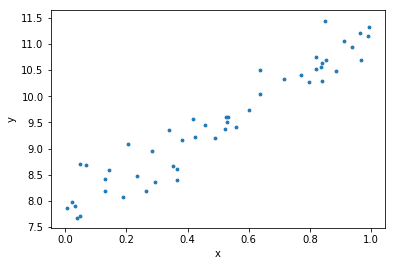

In [3]:
plt.scatter(x,y, s=8); plt.xlabel("x"); plt.ylabel("y"); 

We need a cost/error function in order to tell how well your weights are working, and to update the weights.

We'll use __Mean Squared Error__. That is, take the (prediction-actual), square it, and then take the mean of that for all of the samples you're processing.

In [4]:
def mean_squared_error(prediction, actual):
    return ((prediction-actual)**2).mean()

In [5]:
# Imagine have a = 10 and b = 5
predictions = lin(10, 5, x)
predictions

array([14.65525,  7.04863, 14.88907, 14.11549,  7.94143, 13.53099,  7.84472, 10.23016,  8.65855,  8.37718,
        7.35099, 10.29399, 10.99694,  5.38836, 11.36102, 14.6749 ,  9.90382, 13.18922, 12.16097, 14.93355,
       13.87146,  7.64801,  6.31027,  8.65656, 13.41315,  6.29852, 12.70791, 13.35429, 11.38604, 13.41227,
       10.32819,  8.81089,  6.88663,  9.2564 ,  5.46922, 12.98631, 13.20175,  5.48395,  9.57878,  6.42903,
        5.05591,  5.31259,  5.231  ,  9.18251, 14.38702,  5.66927, 13.50826, 10.24821, 10.60107,  8.52362])

In [6]:
mean_squared_error(predictions, y)

4.749004611062585

In [7]:
# Build a convenience function for this:
def mean_squared_error_loss(a, b, x, y):
    predictions = lin(a, b, x)
    return mean_squared_error(predictions, y)

In [8]:
mean_squared_error_loss(10, 5, x, y)

4.749004611062585

Now we will implement gradient descent, using 10,000 training samples, a=3 and b=8.

In [9]:
x,y = generate_fake_data(10000,3.,8.)

In [10]:
# Next we need to convert these into PyTorch variables.
# Recall variables support all tensor operations, and also automatic differentiation.
x,y = V(x),V(y)

In [11]:
# Now we'll create random variables for a and b
a = V(np.random.randn(1), requires_grad=True)
b = V(np.random.randn(1), requires_grad=True)
a,b

(Variable containing:
  1.5703
 [torch.cuda.FloatTensor of size 1 (GPU 0)], Variable containing:
 -0.2834
 [torch.cuda.FloatTensor of size 1 (GPU 0)])

In [12]:
# Now let's code up the gradient descent algorithm
# Note: What makes this gradient descent is that we're processing all of our data at once.
# In stochastic gradient descent we would only be processing a batch at a time.
learning_rate = 1e-3

# Do 10000 epochs
for iteration in range(10000):
    
    # Forward pass: computer the loss
    loss = mean_squared_error_loss(a,b,x,y)
    
    # Print out the loss every 1000 epochs
    if (iteration % 1000) == 0:
        print (loss.data[0])
        
    # Backward pass
    # Compute the gradient of the loss. Will use all Variables with requires_grad=True
    # After this, a.grad and b.grad will hold the gradient of the loss with respect to a and b
    loss.backward()
    
    # Now update a and b using our computed gradients
    # .grad = variable
    # .data/.grad.data = tensor
    a.data -= learning_rate * a.grad.data
    b.data -= learning_rate * b.grad.data
    
    # Reset the gradients in place
    a.grad.data.zero_()
    b.grad.data.zero_()

81.19774627685547
0.951996386051178
0.36481624841690063
0.2984328866004944
0.24998588860034943
0.21288225054740906
0.1844538152217865
0.16267310082912445
0.14598484337329865
0.13319863379001617


In [13]:
# And check to see if our weights are as they should be...
a, b

(Variable containing:
  3.6181
 [torch.cuda.FloatTensor of size 1 (GPU 0)], Variable containing:
  7.6720
 [torch.cuda.FloatTensor of size 1 (GPU 0)])

In [14]:
# Pretty close!

## Gradient descent for classification
This is pretty similar, but we generate either 0 or 1 for y when generating data, and use a different cost function.

In [15]:
def generate_fake_data_classification(num_of_data, a, b):
    x = s = np.random.uniform(0, 1, num_of_data)
    y = lin(a,b,x) + 0.1 * np.random.normal(0, 3, num_of_data)
    return x, np.where(y>10, 1, 0).astype(np.float32)

In [16]:
x,y = generate_fake_data_classification(10000, 3., 8.)
x,y = V(x),V(y)
x[:5],y[:5]

(Variable containing:
  0.8148
  0.9102
  0.1850
  0.5941
  0.7239
 [torch.cuda.FloatTensor of size 5 (GPU 0)], Variable containing:
  1
  1
  0
  0
  1
 [torch.cuda.FloatTensor of size 5 (GPU 0)])

In [17]:
# Negative log likelihood cost function (I think)
def nll(prediction, y):
    prediction = torch.clamp(prediction, 1e-5, 1-1e-5)
    return (y*prediction.log() + (1-y)*(1-prediction).log()).mean()

In [18]:
# Randomly initialize weights
a = V(np.random.randn(1), requires_grad=True)
b = V(np.random.randn(1), requires_grad=True)

In [19]:
# Gradient descent
learning_rate = 1e-2

for iteration in range(3000):
    # Sigmoid function
    p = (-lin(a,b,x)).exp()
    prediction = 1/(1+p)
    
    loss = nll(prediction, y)
    
    if iteration % 1000 == 0:
        print(loss.data[0], np.mean(to_np(y)==(to_np(prediction)>0.5)))
        
    # Update the weights
    loss.backward()
    
    a.data -= learning_rate * a.grad.data
    b.data -= learning_rate * b.grad.data
    
    a.grad.data.zero_()
    b.grad.data.zero_()

-1.0979423522949219 0.3346
-5.494707107543945 0.3346
-7.653990745544434 0.3346


In [20]:
a,b

(Variable containing:
  3.1199
 [torch.cuda.FloatTensor of size 1 (GPU 0)], Variable containing:
  11.5098
 [torch.cuda.FloatTensor of size 1 (GPU 0)])

## Gradient Descent with NumPy
We could also do gradient descent with pure NumPy. In this case we have to computer the derivatives with respect to each variable (weight) ourselves.

In [21]:
from matplotlib import rcParams, animation, rc
from ipywidgets import interact, interactive, fixed
from ipywidgets.widgets import *
rc('animation', html='html5')
rcParams['figure.figsize'] = 3, 3

In [22]:
x,y = generate_fake_data(50, 3., 8.)

In [23]:
# Set up initial guesses for the weights
a_guess,b_guess = -1.,1.
mean_squared_error_loss(y, a_guess, b_guess, x)

66.76043795624314

In [24]:
learning_rate = 0.01

def update():
    global a_guess, b_guess
    prediction = lin(a_guess, b_guess, x)
    
    # These are the derivatives of our function with respect to the weights
    dydb = 2*(prediction-y)
    dyda = x*dydb
    
    a_guess -= learning_rate*dyda.mean()
    b_guess -= learning_rate*dydb.mean()

In [26]:
# Animate a call
fig = plt.figure(dpi=100, figsize=(5, 4))
plt.scatter(x,y)
line, = plt.plot(x,lin(a_guess,b_guess,x))
plt.close()

def animate(i):
    line.set_ydata(lin(a_guess,b_guess,x))
    for i in range(30): update()
    return line,

ani = animation.FuncAnimation(fig, animate, np.arange(0, 20), interval=100)
ani